In [1]:
import matplotlib.pyplot as plt
#%matplotlib inline

from skimage import data
from skimage import color
from skimage import morphology
from skimage import segmentation
from skimage import filters,io
from skimage.future import graph
from skimage.measure import regionprops
from skimage import draw
from skimage import feature
import networkx as nx

from scipy import ndimage as ndi

from skimage.util import img_as_float
from skimage.filters import gabor_kernel

import pickle

In [2]:
import tensorflow as tf
from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2

from spektral.layers import GraphConv, TopKPool,DiffPool, SAGPool,MinCutPool, GraphSageConv
from spektral.layers import GraphAttention, GlobalAttentionPool
from spektral.layers.ops import sp_matrix_to_sp_tensor
from spektral.utils import normalized_laplacian

import segmentation_models as sm


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [5]:
# Parameters
l2_reg = 5e-4         # Regularization rate for l2
learning_rate = 1e-3  # Learning rate for SGD
batch_size = 2       # Batch size
epochs = 10       # Number of training epochs
es_patience = 200     # Patience fot early stopping

In [6]:
HOME_DIR ="/home/aly/MyProjects/Intelinair/Graph_Conv/"


INPUT = HOME_DIR + "Dataset/batch_1/image_only/"
NDVI = HOME_DIR + "Dataset/batch_1/ndvi_only/"
GT = HOME_DIR + "Dataset/batch_1/masks_only/"
OUTPUT = HOME_DIR + "Dataset/predictions/"

INPUT_VALID = HOME_DIR + "Dataset/batch_1/image_only_val/"
NDVI_VALID = HOME_DIR + "Dataset/batch_1/ndvi_only_val/"
GT_VALID = HOME_DIR + "Dataset/batch_1/masks_only_val/"

INPUT_TEST = HOME_DIR + "Dataset/batch_1/image_only_test/"
NDVI_TEST = HOME_DIR + "Dataset/batch_1/ndvi_only_test/"
GT_TEST = HOME_DIR + "Dataset/batch_1/masks_only_test/"

Defined_CLASSES = [1]
BATCH_SIZE = 32
EPOCHS=200
pickle_train= ['Train_pickle/first_chunck_train_6.pickle','Train_pickle/second_chunck_train_6.pickle','Train_pickle/third_chunck_train_6.pickle']
pickle_val = ['Val_pickle/first_chunck_valid_6.pickle']
pickle_test = ['Test_pickle/first_chunck_test_6.pickle']

In [9]:
import matplotlib.pyplot as plt
from io import BytesIO
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session  

config =  tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

""" This function used to visualize the input, predicted mask and ground truth"""
def visualize(save_status, save_path,flight_code,**images ):
    
    n = len(images)
    plt.figure(figsize=(40,40))
    for i, (name , image) in enumerate(images.items()):
        plt.subplot(1, n, i+1)
        plt.xticks([])
        plt.yticks([])
        # plt.title(str(i+1))
        plt.title(' '.join(name.split('_')).title())
        
        plt.imshow(image,cmap='gray')
    
    if save_status : 
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plt.savefig(save_path+flight_code+'.jpg')    
    plt.show()
    
    
def denormalize(x):
    x_max = np.max(x)
    x_min = np.min(x)
    x = (x-x_min) / (x_max - x_min)
    x = x.clip(0,1)
    return x

In [10]:
from statistics import mean 
def compute_feats(image, kernels):
    feats = []
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats.append(filtered.mean())
        feats.append(filtered.std())
    return feats
def compute_rgb_hist_feats(image):
    chans = cv2.split(image)

    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        cv2.normalize(hist,hist, 0, 255, cv2.NORM_MINMAX)
        j = []
        for i in hist:
            j.append(np.mean(i))
        j = np.asarray(j)    
        features.append(np.mean(j))
        
    return features
def make_ganbor_bank_kernels():
    kernels = []
    for theta in range(4):
        theta = theta / 4. * np.pi
        for sigma in (1, 3):
            for frequency in (0.05, 0.25):
                kernel = np.real(gabor_kernel(frequency, theta=theta,
                                              sigma_x=sigma, sigma_y=sigma))
                kernel = np.stack((kernel,kernel,kernel),axis = 2)
                #print(kernel.shape)
                kernels.append(kernel)
    return kernels

In [11]:
kernels = make_ganbor_bank_kernels()
def find_bounding_contour_and_cal_features(segments,image, prev_node_no,nutrient_mask):
    # loop over the unique segment values
    image_copy = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    all_features = []
    all_labels= []
    ##for node 0
    list_zeros = (np.zeros(9)).tolist()
    all_features.append(list_zeros)
    all_labels.append(0)
    for (i, segVal) in enumerate(np.unique(segments)):
    # construct a mask for the segment
        if i > 0:
            #print("[x] inspecting segment %d" % (i))
            mask = np.zeros(image_copy.shape[:2], dtype = "uint8")
            mask[segments == segVal] = 255
        #   # show the masked region
        #   cv2.imshow("Mask", mask)
        #   cv2.imshow("Applied", cv2.bitwise_and(image, image, mask = mask))
            result = cv2.bitwise_and(image_copy, image_copy, mask = mask)
            cnt,_ = cv2.findContours(result,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            x,y,w,h = cv2.boundingRect(cnt[0])
            #print('x:{},y:{},w:{},h:{}'.format(x,y,w,h))
            roi = image[y:y+w, x:x+h]
            roi_mask = nutrient_mask[y:y+w, x:x+h]
            roi_feats =[] #compute_feats(image=roi, kernels=kernels)
            roi_feats.extend((np.mean(roi, axis=(0, 1))).tolist())
            roi_feats.extend((np.mean(roi, axis=(0, 1))).tolist())
            roi_feats.extend((compute_rgb_hist_feats(roi)))
            all_features.append(roi_feats)
            if cv2.countNonZero(roi_mask) > 0.5*w*h:
                all_labels.append(1)
            else:
                all_labels.append(0)
            #if image is not None:
                #image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
                #cv2.drawContours(image, cnt[0], -1, (0,255,0), 1)
                #cv2.rectangle(image,(x,y),(x+w,y+h), (255,0,0), 2)
                #cv2.imshow("", image)
               # cv2.imshow("roi",roi)
                #cv2.waitKey(1000)
        #   cv2.waitKey(0)
    while prev_node_no < 401:
        list_zero = (np.zeros(9)).tolist()
        all_features.append(list_zeros)
        all_labels.append(0)
        prev_node_no += 1
    return all_features, all_labels

In [12]:

def Graph_model(N,F):
    
    tf.compat.v1.disable_eager_execution()
    # Model definition
   
    # Pass A as a fixed tensor, otherwise Keras will complain about inputs of
    # different rank.
    X_in = Input(shape=(N, F))
    A_in = Input(shape=(N,N)) #tensor=sp_matrix_to_sp_tensor(fltr))
    #I_in = Input(shape=(), name='segment_ids_in', dtype=tf.int32)
    
    X_1 = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_in, A_in])
    #[X_g_pool,A_g_pool] = TopKPool(0.5)([graph_conv_1, A_in])
    #pool = MinCutPool(200)([X_1, A_in])
    #X_1, A_1, I_1 = TopKPool(ratio=0.5)([X_1, A_in, I_in])
    X_2 = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_1, A_in])
    X_3 = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_2, A_in])
    X_4 = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_3, A_in])
    X_5 = GraphConv(32,
                           activation='elu',
                           kernel_regularizer=l2(l2_reg),
                           use_bias=True)([X_4, A_in])
    X_6 = GraphConv(1,activation='sigmoid')([X_5, A_in])
    #flatten = Flatten()(X2)
    #fc = Dense(512, activation='relu')(flatten)
    #output = Dense(2, activation='softmax')(fc)

    # Build model
    model = Model(inputs=[X_in, A_in], outputs=X_6)
    optimizer = Adam(lr=0.001)
    dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.7,0.3])) 
    focal_loss = sm.losses.BinaryFocalLoss() 
    total_loss = dice_loss + (1 * focal_loss)
    model.compile(optimizer=optimizer,
                  loss=dice_loss,
                  metrics=[sm.metrics.Precision(), sm.metrics.Recall(), sm.metrics.IOUScore(threshold =0.5), sm.metrics.FScore(threshold = 0.5)])
    model.summary()
    return model

In [13]:
G = Graph_model(401,9)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 401, 9)       0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 401, 401)     0                                            
__________________________________________________________________________________________________
graph_conv_7 (GraphConv)        (None, 401, 32)      320         input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
graph_conv_8 (GraphConv)        (None, 401, 32)      1056        graph_conv_7[0][0]               
         

In [10]:
    
class Dataset_2:
    
    CLASSES = Defined_CLASSES
    def __init__(
            self,
            pickel_list,
            classes = None,
            augmentation = None,
            preprocessing = None
            ):
        """ make a list of image directions  """
        self.flight_codes = []
        self.Adjacency = []
        self.features = []
        self.pixel_labels=[]
        self.y_label = []
        self.nutrient_mask = []
        for f in pickel_list:
            with open(f, 'rb') as handle:
                self.flights = pickle.load(handle)
        
            for code in self.flights.keys():
                self.flight_codes.append(code)
                self.Adjacency.append(self.flights[code]['A'])
                self.features.append(self.flights[code]['X'])
                self.pixel_labels.append(self.flights[code]['pixel_labels'])
                self.y_label.append(self.flights[code]['Y'])
                self.nutrient_mask.append(self.flights[code]['nutrient_mask'])
        
        """ set the class values and assign a augmentation and preprocessing method"""
        # self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = classes
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
    def __getitem__(self,i):
         
        X= self.features[i]
        A= self.Adjacency[i]
        A = normalized_laplacian(A)
        for e in range(1,len(A[0])):
            if A[0][e] > 0 :
                A[0][e] =0
                A[e][0] = 0
                
        pixel_labels = self.pixel_labels[i]
        code = self.flight_codes[i]
        Y= self.y_label[i]
        nutrient_mask = self.nutrient_mask[i]
        
        return A, X,Y,code, nutrient_mask,pixel_labels
    
    def __len__(self):
        return len(self.flight_codes)
    
class Dataloader_2(keras.utils.Sequence):
    
    def __init__(
            self,
            dataset,
            batch_size = 1,
            shuffle = False
            ):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))
        
        self.on_epoch_end()
        
    def __getitem__(self, i):
        
        start = i * self.batch_size
        stop = (i+1) * self.batch_size
        X_A = []
        X_X = []
        y = np.empty((self.batch_size,401,1), dtype=int)
        for j in range(start, stop):
            #data.append([self.dataset[j][0],self.dataset[j][0]],self.dataset[j][1])
            #a,x, = self.dataset[j]
            X_A.append(self.dataset[j][0])
            X_X.append(self.dataset[j][1])
            y[j-start] = np.expand_dims(self.dataset[j][2], axis=1)
        
        #for samples in data:
        #    print(samples)
        #batch = [np.stack(samples, axis = 0) for samples in zip(*data)]
        X= [np.array(X_X),np.array(X_A) ]
        return X, y          
    
    def __len__(self):
        """  the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [11]:
""" loading traind and validation dataset """
train_dataset = Dataset_2(pickel_list= pickle_train,classes = Defined_CLASSES)

valid_dataset = Dataset_2(pickel_list= pickle_val,classes = Defined_CLASSES)

train_dataloader = Dataloader_2(train_dataset, batch_size = BATCH_SIZE, shuffle = True )
valid_dataloader = Dataloader_2(valid_dataset, batch_size = 1, shuffle = False )




Epoch 1/200


/home/aly/anaconda3/envs/graph/lib/python3.7/site-packages/spektral/utils/convolution.py:28: RuntimeWarning: divide by zero encountered in power
  degrees = np.power(np.array(adj.sum(1)), pow).flatten()






6/6 [==============================] - 4s 623ms/step - loss: 1.0664 - precision: 0.0043 - recall: 0.5864 - iou_score: 0.0046 - f1-score: 0.0091 - val_loss: 1.0677 - val_precision: 0.0013 - val_recall: 0.9715 - val_iou_score: 0.0018 - val_f1-score: 0.0035
Epoch 2/200
6/6 [==============================] - 2s 399ms/step - loss: 1.0623 - precision: 0.0055 - recall: 0.7337 - iou_score: 0.0057 - f1-score: 0.0114 - val_loss: 1.0646 - val_precision: 0.0014 - val_recall: 0.9756 - val_iou_score: 0.0018 - val_f1-score: 0.0034
Epoch 3/200
6/6 [==============================] - 3s 505ms/step - loss: 1.0587 - precision: 0.0060 - recall: 0.8044 - iou_score: 0.0066 - f1-score: 0.0129 - val_loss: 1.0616 - val_precision: 0.0014 - val_recall: 0.9762 - val_iou_score: 0.0016 - val_f1-score: 0.0030
Epoch 4/200
6/6 [==============================] - 3s 434ms/step - loss: 1.0553 - precision: 0.0065 - recall: 0.8239 - iou_score: 0.0073 - f1-score: 0.0144 - val_loss: 1.0586 - val_precision: 0.0014 - val_re

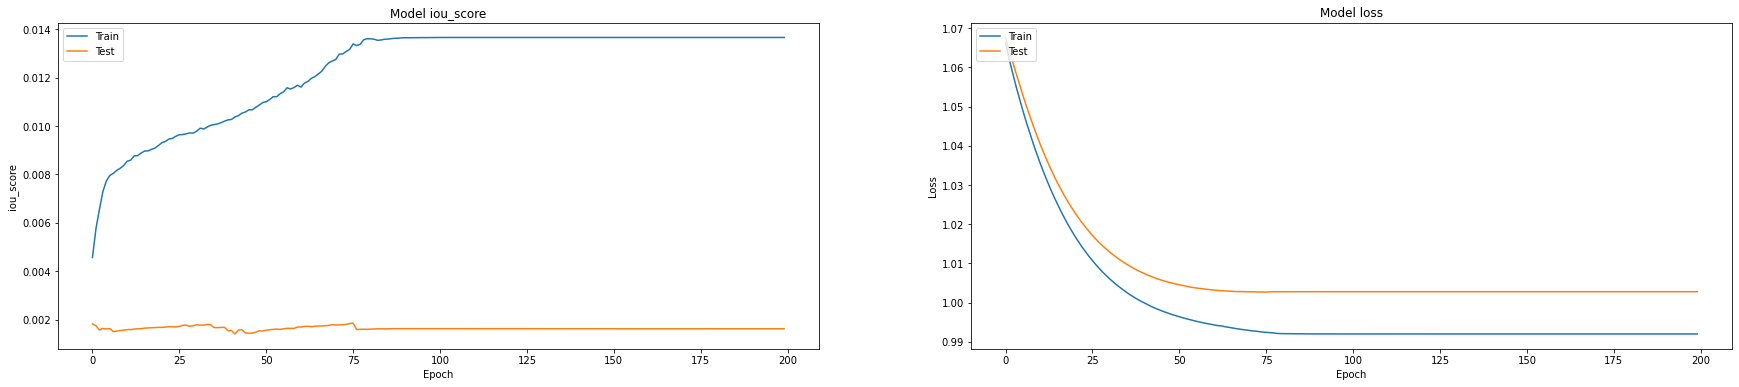

In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint('Graph_conv_net'+'.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
    ]

history = G.fit_generator(
    train_dataloader,
    steps_per_epoch = len(train_dataloader),
    epochs = EPOCHS,
    callbacks = callbacks,
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
    )

""" Plot training & validation iou_score values """
plt.figure(figsize=(30, 6))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

""" Plot training & validation loss values """
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# """ Plot training & validation f1-score values """
# plt.subplot(123)
# plt.plot(history.history['f1-score'])
# plt.plot(history.history['val_f1-score'])
# plt.title('Model f1-score')
# plt.ylabel('f1-score')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# # plt.show()
# plt.savefig('training_loss_IOU_f1.png')

In [13]:
scores = G.evaluate_generator(valid_dataloader)
print(scores)

[1.0027922696255622, 0.0016966704650296276, 0.9733526338922217, 0.0016214059416415874, 0.0031711589057843766]


In [14]:
def map_value_to_pixels(labels, value):
    x = np.zeros((labels.shape[0],labels.shape[1]))
    for i,v in enumerate(value):
        #if v > 0.5 :
        x[labels == i] = v
    
    return x

In [15]:
dataset = Dataset_2(pickel_list= pickle_test,classes = Defined_CLASSES)
flights = {}
for i in range(0,5):
    A, X,Y,flight_code, nutrient_mask,labels= dataset[i]
    A = np.expand_dims(A, axis=0)
    X = np.expand_dims(X, axis=0)
    p = G.predict([X,A])
    #print(p)
    w1=map_value_to_pixels(labels,Y)#, p[...,0].squeeze())
    w2=map_value_to_pixels(labels,p[...,0].squeeze())

    print(flight_code)
    visualize(
        save_status = False,
        save_path = ''#HOME_DIR+'Scripts/Results/regression/',
        flight_code = flight_code,
        predict=nutrient_mask[...,0].squeeze(),
        #labels = labels,
        w2 = w2,
        w1 = w1,
        
    ) 
        

SyntaxError: invalid syntax (<ipython-input-15-f6b35b3166a2>, line 16)